## Preparation

### Download the optimization support library package

In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.7 MB/s eta 0:00:00


### Connect to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Import Libraries

In [3]:
# Library to support working with data
import numpy as np
import pandas as pd

# Graphing support library
import matplotlib.pyplot as plt

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Library to support building Temporal Convolutional Attention Networks models
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Layer, RepeatVector, concatenate, Reshape, Input, Concatenate, Permute, Multiply, Add, Activation

# Performance metrics calculation support library
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

# Parameter optimization support library
import optuna

# Support library to ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Support library to load models and data
from keras.utils import custom_object_scope
from tensorflow.keras.models import load_model

## Data preprocessing

### Read data

In [4]:
# Load data
df = pd.read_csv('INTC.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,45.959999,47.470001,45.770000,47.080002,41.343937,18774600
1,2019-01-03,46.150002,46.279999,44.389999,44.490002,39.069477,32267300
2,2019-01-04,45.840000,47.570000,45.540001,47.220001,41.466869,35447300
3,2019-01-07,47.099998,48.000000,46.750000,47.439999,41.660065,22736800
4,2019-01-08,47.799999,48.029999,46.779999,47.740002,41.923512,22749200
...,...,...,...,...,...,...,...
1114,2023-06-06,29.770000,31.450001,29.700001,30.959999,30.959999,42295300
1115,2023-06-07,31.030001,31.370001,30.930000,31.280001,31.280001,39098000
1116,2023-06-08,31.430000,31.850000,31.059999,31.820000,31.820000,35199000
1117,2023-06-09,31.930000,31.990000,30.680000,31.340000,31.340000,40218000


### Reset index

In [5]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [6]:
# Select column 'Close'
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

### Data normalization

In [7]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))

### Data splitting

In [8]:
# Split the data into train, validation, and test dataset in a ratio of 7:1:2
train_size = int(len(data_scaled) * 0.7)
val_size = int(len(data_scaled) * 0.1)
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

## Model training and testing

In [9]:
# Generating data using the window sliding method
def create_dataset(data, window_size):
    windows, targets = [], []
    for i in range(len(data) - window_size - 1):
        windows.append(data[i : (i + window_size), 0])
        targets.append(data[i + window_size, 0])
    return np.array(windows), np.array(targets)

### Building TCANs model

In [10]:
# Constructing sparse attention layer
class AttentionLayer(Layer):
    def __init__(self, attention_dim):
        super(AttentionLayer, self).__init__()
        self.attention_dim = attention_dim

    def build(self, input_shape):
        self.W1 = Dense(units=self.attention_dim, activation='tanh')
        self.W2 = Dense(units=1, activation='linear')
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        score = self.W2(self.W1(x))
        score = Flatten()(score)
        score = Activation('softmax')(score)
        score = RepeatVector(x.shape[-1])(score)
        score = Permute([2, 1])(score)
        return Multiply()([x, score])

    def compute_output_shape(self, input_shape):
        return input_shape

In [11]:
# Build TCAN model
def build_tcan(window_size, input_dim=1, tcn_filters=64, tcn_kernel_size=2, dropout_rate=0.2, attention_dim=16):
    inputs = Input(shape=(window_size, input_dim))
    x = inputs
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)

    # Additive Attention
    att = AttentionLayer(attention_dim)(x)
    max_pool_att = GlobalMaxPooling1D()(att)
    max_pool_x = GlobalMaxPooling1D()(x)
    x = concatenate([max_pool_att, max_pool_x])

    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)

    return model

### Learning process with combined parameter optimization

In [12]:
# Initialization of optimization parameters
best_mse = float('inf')
best_model = None
best_window_size = None
best_train_windows = None
best_train_targets = None
best_test_windows = None
best_test_targets = None
best_val_windows = None
best_val_targets = None
best_y_pred = None
best_mape = np.inf
best_rmse = np.inf
best_msle = np.inf

In [13]:
# Define the objective function for Optuna optimization
def objective(trial):
  global best_mse, best_model, best_window_size, best_train_windows
  global best_train_targets, best_test_windows, best_test_targets, best_val_windows
  global best_val_targets, best_y_pred, best_mape, best_rmse, best_msle

  # Define the search space for hyperparameters
  window_size = trial.suggest_int("window_size", 10, 100)
  tcn_filters = trial.suggest_int("tcn_filters", 32, 128)
  tcn_kernel_size = trial.suggest_int("tcn_kernel_size", 2, 5)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
  attention_dim = trial.suggest_int("attention_dim", 8, 32)

  # Build the TCAN model with the suggested hyperparameters
  model = build_tcan(window_size,
                     tcn_filters = tcn_filters,
                     tcn_kernel_size = tcn_kernel_size,
                     dropout_rate = dropout_rate,
                     attention_dim = attention_dim)

  train_windows, train_targets = create_dataset(train_data, window_size)
  test_windows, test_targets = create_dataset(test_data, window_size)
  val_windows, val_targets = create_dataset(val_data, window_size)

  # Train the model
  early_stop = EarlyStopping(monitor='val_loss', patience=5)
  model.fit(train_windows, train_targets,
            epochs=50, batch_size=32,
            validation_data=(val_windows, val_targets),
            shuffle=False, callbacks=[early_stop], verbose=0)

  # Testing the model on Test dataset
  y_pred = model.predict(test_windows)

  # Evaluate on MAPE, RMSE, MSLE
  temp_test_targets = test_targets
  temp_test_targets = scaler.inverse_transform(temp_test_targets.reshape(-1, 1))
  y_pred = scaler.inverse_transform(y_pred)

  mse = mean_squared_error(temp_test_targets, y_pred)
  rmse = np.sqrt(mse)
  mape = mean_absolute_percentage_error(temp_test_targets, y_pred)
  msle = mean_squared_log_error(temp_test_targets, y_pred)

  # Save the best model and related information
  if mse < best_mse or best_mse is None:
    best_model = model
    best_window_size = window_size
    best_y_pred = y_pred
    best_train_windows = train_windows
    best_train_targets = train_targets
    best_test_windows = test_windows
    best_test_targets = test_targets
    best_val_windows = val_windows
    best_val_targets = val_targets
    best_rmse = rmse
    best_mape = mape
    best_msle = msle
    best_mse = mse

  return mse

In [14]:
# Define the search space for the hyperparameters
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2023-06-14 05:04:40,036] A new study created in memory with name: no-name-077e7534-8fc2-40be-925b-9f94f3352d54


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 05:05:15,725] Trial 0 finished with value: 33.17303667602889 and parameters: {'window_size': 81, 'tcn_filters': 74, 'tcn_kernel_size': 2, 'dropout_rate': 0.25937583780687234, 'attention_dim': 30}. Best is trial 0 with value: 33.17303667602889.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 05:05:27,867] Trial 1 finished with value: 56.55438275332265 and parameters: {'window_size': 70, 'tcn_filters': 65, 'tcn_kernel_size': 5, 'dropout_rate': 0.4605549186778666, 'attention_dim': 29}. Best is trial 0 with value: 33.17303667602889.


6/6 [==============================] - 0s 8ms/step


[I 2023-06-14 05:05:40,414] Trial 2 finished with value: 36.847394388954406 and parameters: {'window_size': 61, 'tcn_filters': 110, 'tcn_kernel_size': 4, 'dropout_rate': 0.47280607573792255, 'attention_dim': 11}. Best is trial 0 with value: 33.17303667602889.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 05:05:52,497] Trial 3 finished with value: 40.32594849816163 and parameters: {'window_size': 34, 'tcn_filters': 62, 'tcn_kernel_size': 5, 'dropout_rate': 0.2237561853927363, 'attention_dim': 18}. Best is trial 0 with value: 33.17303667602889.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-14 05:06:04,696] Trial 4 finished with value: 60.02130329166804 and parameters: {'window_size': 47, 'tcn_filters': 40, 'tcn_kernel_size': 2, 'dropout_rate': 0.13712554694294582, 'attention_dim': 8}. Best is trial 0 with value: 33.17303667602889.


6/6 [==============================] - 0s 8ms/step


[I 2023-06-14 05:06:27,506] Trial 5 finished with value: 49.8150080440134 and parameters: {'window_size': 37, 'tcn_filters': 120, 'tcn_kernel_size': 5, 'dropout_rate': 0.39456249555060185, 'attention_dim': 17}. Best is trial 0 with value: 33.17303667602889.


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 05:06:50,053] Trial 6 finished with value: 13.735953366266587 and parameters: {'window_size': 93, 'tcn_filters': 47, 'tcn_kernel_size': 5, 'dropout_rate': 0.11859651287006186, 'attention_dim': 20}. Best is trial 6 with value: 13.735953366266587.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 05:07:02,133] Trial 7 finished with value: 31.5528194300452 and parameters: {'window_size': 22, 'tcn_filters': 67, 'tcn_kernel_size': 4, 'dropout_rate': 0.15162913365781328, 'attention_dim': 25}. Best is trial 6 with value: 13.735953366266587.


5/5 [==============================] - 0s 14ms/step


[I 2023-06-14 05:07:24,617] Trial 8 finished with value: 14.01433285258411 and parameters: {'window_size': 86, 'tcn_filters': 121, 'tcn_kernel_size': 5, 'dropout_rate': 0.2518900109349158, 'attention_dim': 9}. Best is trial 6 with value: 13.735953366266587.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 05:07:37,953] Trial 9 finished with value: 52.518486159719224 and parameters: {'window_size': 61, 'tcn_filters': 110, 'tcn_kernel_size': 2, 'dropout_rate': 0.421466838556637, 'attention_dim': 17}. Best is trial 6 with value: 13.735953366266587.


4/4 [==============================] - 0s 6ms/step


[I 2023-06-14 05:07:50,028] Trial 10 finished with value: 117.87270447532352 and parameters: {'window_size': 98, 'tcn_filters': 34, 'tcn_kernel_size': 3, 'dropout_rate': 0.33477808603686876, 'attention_dim': 23}. Best is trial 6 with value: 13.735953366266587.


4/4 [==============================] - 0s 16ms/step


[I 2023-06-14 05:08:11,386] Trial 11 finished with value: 14.147116425446663 and parameters: {'window_size': 97, 'tcn_filters': 92, 'tcn_kernel_size': 4, 'dropout_rate': 0.1101128298770202, 'attention_dim': 13}. Best is trial 6 with value: 13.735953366266587.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 05:08:29,555] Trial 12 finished with value: 23.422082010433762 and parameters: {'window_size': 84, 'tcn_filters': 89, 'tcn_kernel_size': 5, 'dropout_rate': 0.2098007079109233, 'attention_dim': 22}. Best is trial 6 with value: 13.735953366266587.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 05:08:41,237] Trial 13 finished with value: 49.85370356228635 and parameters: {'window_size': 82, 'tcn_filters': 51, 'tcn_kernel_size': 3, 'dropout_rate': 0.29445130830952476, 'attention_dim': 12}. Best is trial 6 with value: 13.735953366266587.


4/4 [==============================] - 0s 11ms/step


[I 2023-06-14 05:08:58,121] Trial 14 finished with value: 11.132478191763164 and parameters: {'window_size': 99, 'tcn_filters': 90, 'tcn_kernel_size': 4, 'dropout_rate': 0.16662438895272996, 'attention_dim': 27}. Best is trial 14 with value: 11.132478191763164.


4/4 [==============================] - 0s 11ms/step


[I 2023-06-14 05:09:20,508] Trial 15 finished with value: 23.120934119608453 and parameters: {'window_size': 97, 'tcn_filters': 90, 'tcn_kernel_size': 4, 'dropout_rate': 0.17389487088999458, 'attention_dim': 26}. Best is trial 14 with value: 11.132478191763164.


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 05:09:32,639] Trial 16 finished with value: 17.63819178317043 and parameters: {'window_size': 74, 'tcn_filters': 49, 'tcn_kernel_size': 3, 'dropout_rate': 0.12071272868844517, 'attention_dim': 32}. Best is trial 14 with value: 11.132478191763164.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 05:09:47,480] Trial 17 finished with value: 12.022131573033011 and parameters: {'window_size': 92, 'tcn_filters': 81, 'tcn_kernel_size': 4, 'dropout_rate': 0.1767257901359372, 'attention_dim': 21}. Best is trial 14 with value: 11.132478191763164.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 05:10:04,104] Trial 18 finished with value: 15.081507577844958 and parameters: {'window_size': 72, 'tcn_filters': 100, 'tcn_kernel_size': 4, 'dropout_rate': 0.18779256209011175, 'attention_dim': 27}. Best is trial 14 with value: 11.132478191763164.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 05:10:08,810] Trial 19 finished with value: 26.476281330689506 and parameters: {'window_size': 17, 'tcn_filters': 80, 'tcn_kernel_size': 3, 'dropout_rate': 0.17195017837277546, 'attention_dim': 23}. Best is trial 14 with value: 11.132478191763164.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 05:10:32,612] Trial 20 finished with value: 7.826812237652092 and parameters: {'window_size': 89, 'tcn_filters': 77, 'tcn_kernel_size': 4, 'dropout_rate': 0.1021659725950719, 'attention_dim': 20}. Best is trial 20 with value: 7.826812237652092.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 05:10:45,152] Trial 21 finished with value: 9.026271191247785 and parameters: {'window_size': 88, 'tcn_filters': 80, 'tcn_kernel_size': 4, 'dropout_rate': 0.11240822708840871, 'attention_dim': 20}. Best is trial 20 with value: 7.826812237652092.


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 05:11:03,452] Trial 22 finished with value: 7.425062709387307 and parameters: {'window_size': 89, 'tcn_filters': 102, 'tcn_kernel_size': 4, 'dropout_rate': 0.10240364952890924, 'attention_dim': 15}. Best is trial 22 with value: 7.425062709387307.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 05:11:19,022] Trial 23 finished with value: 7.289776959595943 and parameters: {'window_size': 75, 'tcn_filters': 101, 'tcn_kernel_size': 4, 'dropout_rate': 0.10303868524013297, 'attention_dim': 15}. Best is trial 23 with value: 7.289776959595943.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 05:11:39,434] Trial 24 finished with value: 11.620211750249691 and parameters: {'window_size': 76, 'tcn_filters': 101, 'tcn_kernel_size': 3, 'dropout_rate': 0.10391792359741747, 'attention_dim': 15}. Best is trial 23 with value: 7.289776959595943.


5/5 [==============================] - 0s 14ms/step


[I 2023-06-14 05:11:51,677] Trial 25 finished with value: 7.496390518099557 and parameters: {'window_size': 64, 'tcn_filters': 108, 'tcn_kernel_size': 4, 'dropout_rate': 0.14315470571674738, 'attention_dim': 15}. Best is trial 23 with value: 7.289776959595943.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 05:12:14,148] Trial 26 finished with value: 13.465951677352498 and parameters: {'window_size': 64, 'tcn_filters': 128, 'tcn_kernel_size': 3, 'dropout_rate': 0.14426466801585003, 'attention_dim': 14}. Best is trial 23 with value: 7.289776959595943.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 05:12:27,060] Trial 27 finished with value: 11.868318848348398 and parameters: {'window_size': 56, 'tcn_filters': 106, 'tcn_kernel_size': 4, 'dropout_rate': 0.14123304884005616, 'attention_dim': 15}. Best is trial 23 with value: 7.289776959595943.


6/6 [==============================] - 0s 16ms/step


[I 2023-06-14 05:12:49,653] Trial 28 finished with value: 21.225808970032773 and parameters: {'window_size': 53, 'tcn_filters': 116, 'tcn_kernel_size': 4, 'dropout_rate': 0.2079594438823847, 'attention_dim': 18}. Best is trial 23 with value: 7.289776959595943.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 05:13:13,053] Trial 29 finished with value: 31.570933834570752 and parameters: {'window_size': 68, 'tcn_filters': 101, 'tcn_kernel_size': 3, 'dropout_rate': 0.14527720506727945, 'attention_dim': 10}. Best is trial 23 with value: 7.289776959595943.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 05:13:35,503] Trial 30 finished with value: 17.288288568903834 and parameters: {'window_size': 79, 'tcn_filters': 97, 'tcn_kernel_size': 5, 'dropout_rate': 0.1934749727992679, 'attention_dim': 16}. Best is trial 23 with value: 7.289776959595943.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 05:13:57,938] Trial 31 finished with value: 9.599167944933257 and parameters: {'window_size': 79, 'tcn_filters': 73, 'tcn_kernel_size': 4, 'dropout_rate': 0.10004409866157453, 'attention_dim': 13}. Best is trial 23 with value: 7.289776959595943.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 05:14:12,447] Trial 32 finished with value: 7.925278692034106 and parameters: {'window_size': 89, 'tcn_filters': 109, 'tcn_kernel_size': 4, 'dropout_rate': 0.13374370371573077, 'attention_dim': 19}. Best is trial 23 with value: 7.289776959595943.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 05:14:23,573] Trial 33 finished with value: 6.313124607368397 and parameters: {'window_size': 66, 'tcn_filters': 85, 'tcn_kernel_size': 4, 'dropout_rate': 0.1036030796386568, 'attention_dim': 15}. Best is trial 33 with value: 6.313124607368397.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 05:14:45,898] Trial 34 finished with value: 11.825393721945257 and parameters: {'window_size': 67, 'tcn_filters': 96, 'tcn_kernel_size': 4, 'dropout_rate': 0.15332973027696717, 'attention_dim': 11}. Best is trial 33 with value: 6.313124607368397.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 05:15:08,243] Trial 35 finished with value: 11.697463051452303 and parameters: {'window_size': 48, 'tcn_filters': 115, 'tcn_kernel_size': 4, 'dropout_rate': 0.12853668731285187, 'attention_dim': 15}. Best is trial 33 with value: 6.313124607368397.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 05:15:20,758] Trial 36 finished with value: 12.714508943689463 and parameters: {'window_size': 57, 'tcn_filters': 86, 'tcn_kernel_size': 5, 'dropout_rate': 0.15980570363068353, 'attention_dim': 13}. Best is trial 33 with value: 6.313124607368397.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 05:15:44,100] Trial 37 finished with value: 5.69472504532236 and parameters: {'window_size': 70, 'tcn_filters': 104, 'tcn_kernel_size': 5, 'dropout_rate': 0.12765223193351588, 'attention_dim': 11}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 17ms/step


[I 2023-06-14 05:16:06,761] Trial 38 finished with value: 20.3283540098824 and parameters: {'window_size': 72, 'tcn_filters': 105, 'tcn_kernel_size': 5, 'dropout_rate': 0.12556206794955516, 'attention_dim': 8}. Best is trial 37 with value: 5.69472504532236.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 05:16:17,351] Trial 39 finished with value: 29.4693858235594 and parameters: {'window_size': 47, 'tcn_filters': 71, 'tcn_kernel_size': 5, 'dropout_rate': 0.2291228228986994, 'attention_dim': 11}. Best is trial 37 with value: 5.69472504532236.


6/6 [==============================] - 0s 5ms/step


[I 2023-06-14 05:16:29,486] Trial 40 finished with value: 41.19569484186679 and parameters: {'window_size': 37, 'tcn_filters': 61, 'tcn_kernel_size': 2, 'dropout_rate': 0.1296506935574995, 'attention_dim': 9}. Best is trial 37 with value: 5.69472504532236.


6/6 [==============================] - 0s 8ms/step


[I 2023-06-14 05:16:51,854] Trial 41 finished with value: 9.034096157588342 and parameters: {'window_size': 63, 'tcn_filters': 114, 'tcn_kernel_size': 4, 'dropout_rate': 0.10016186362875376, 'attention_dim': 17}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 05:17:06,222] Trial 42 finished with value: 11.80184687180733 and parameters: {'window_size': 66, 'tcn_filters': 123, 'tcn_kernel_size': 5, 'dropout_rate': 0.15348817540862086, 'attention_dim': 16}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 05:17:49,163] Trial 43 finished with value: 19.370030911703964 and parameters: {'window_size': 78, 'tcn_filters': 95, 'tcn_kernel_size': 5, 'dropout_rate': 0.12353604422508961, 'attention_dim': 14}. Best is trial 37 with value: 5.69472504532236.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 05:18:01,887] Trial 44 finished with value: 6.396502125819326 and parameters: {'window_size': 59, 'tcn_filters': 105, 'tcn_kernel_size': 4, 'dropout_rate': 0.12429852201240112, 'attention_dim': 12}. Best is trial 37 with value: 5.69472504532236.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 05:18:25,264] Trial 45 finished with value: 20.145218819317044 and parameters: {'window_size': 58, 'tcn_filters': 85, 'tcn_kernel_size': 4, 'dropout_rate': 0.12776986509232702, 'attention_dim': 12}. Best is trial 37 with value: 5.69472504532236.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 05:18:37,650] Trial 46 finished with value: 14.686985794409283 and parameters: {'window_size': 52, 'tcn_filters': 105, 'tcn_kernel_size': 5, 'dropout_rate': 0.15921839952193742, 'attention_dim': 10}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 05:18:53,343] Trial 47 finished with value: 10.753431933029102 and parameters: {'window_size': 70, 'tcn_filters': 94, 'tcn_kernel_size': 3, 'dropout_rate': 0.11584263135436212, 'attention_dim': 12}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 19ms/step


[I 2023-06-14 05:19:15,913] Trial 48 finished with value: 7.235266165451915 and parameters: {'window_size': 83, 'tcn_filters': 112, 'tcn_kernel_size': 4, 'dropout_rate': 0.18346583206232633, 'attention_dim': 18}. Best is trial 37 with value: 5.69472504532236.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 05:19:38,983] Trial 49 finished with value: 30.570559221657213 and parameters: {'window_size': 42, 'tcn_filters': 112, 'tcn_kernel_size': 5, 'dropout_rate': 0.1866902573325162, 'attention_dim': 17}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 05:20:01,440] Trial 50 finished with value: 11.336767149343084 and parameters: {'window_size': 83, 'tcn_filters': 120, 'tcn_kernel_size': 4, 'dropout_rate': 0.16856527783768904, 'attention_dim': 10}. Best is trial 37 with value: 5.69472504532236.


6/6 [==============================] - 0s 13ms/step


[I 2023-06-14 05:20:12,499] Trial 51 finished with value: 7.288403413499423 and parameters: {'window_size': 60, 'tcn_filters': 103, 'tcn_kernel_size': 4, 'dropout_rate': 0.11686091023116031, 'attention_dim': 18}. Best is trial 37 with value: 5.69472504532236.


6/6 [==============================] - 0s 8ms/step


[I 2023-06-14 05:20:23,966] Trial 52 finished with value: 7.768544838480693 and parameters: {'window_size': 60, 'tcn_filters': 117, 'tcn_kernel_size': 4, 'dropout_rate': 0.11883673435351473, 'attention_dim': 18}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 05:20:37,354] Trial 53 finished with value: 6.179271787569356 and parameters: {'window_size': 75, 'tcn_filters': 98, 'tcn_kernel_size': 4, 'dropout_rate': 0.14155178225701193, 'attention_dim': 19}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 05:21:00,055] Trial 54 finished with value: 10.623456010885405 and parameters: {'window_size': 70, 'tcn_filters': 87, 'tcn_kernel_size': 4, 'dropout_rate': 0.13946990160917022, 'attention_dim': 19}. Best is trial 37 with value: 5.69472504532236.


6/6 [==============================] - 0s 8ms/step


[I 2023-06-14 05:21:16,609] Trial 55 finished with value: 20.25091290120744 and parameters: {'window_size': 51, 'tcn_filters': 112, 'tcn_kernel_size': 4, 'dropout_rate': 0.16026522046519098, 'attention_dim': 22}. Best is trial 37 with value: 5.69472504532236.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 05:21:31,936] Trial 56 finished with value: 23.548169721873066 and parameters: {'window_size': 60, 'tcn_filters': 98, 'tcn_kernel_size': 3, 'dropout_rate': 0.11954660578733574, 'attention_dim': 19}. Best is trial 37 with value: 5.69472504532236.


7/7 [==============================] - 0s 5ms/step


[I 2023-06-14 05:21:40,199] Trial 57 finished with value: 14.996012738968085 and parameters: {'window_size': 27, 'tcn_filters': 93, 'tcn_kernel_size': 4, 'dropout_rate': 0.17510949005925186, 'attention_dim': 21}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 05:22:03,171] Trial 58 finished with value: 6.923584877271986 and parameters: {'window_size': 85, 'tcn_filters': 105, 'tcn_kernel_size': 4, 'dropout_rate': 0.13661669646299474, 'attention_dim': 16}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 15ms/step


[I 2023-06-14 05:22:25,675] Trial 59 finished with value: 10.273693404484696 and parameters: {'window_size': 93, 'tcn_filters': 108, 'tcn_kernel_size': 4, 'dropout_rate': 0.1484595836992715, 'attention_dim': 16}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 05:22:48,110] Trial 60 finished with value: 7.187382574169636 and parameters: {'window_size': 85, 'tcn_filters': 127, 'tcn_kernel_size': 3, 'dropout_rate': 0.18224882531360193, 'attention_dim': 14}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 05:23:10,491] Trial 61 finished with value: 17.624054602133473 and parameters: {'window_size': 85, 'tcn_filters': 123, 'tcn_kernel_size': 3, 'dropout_rate': 0.18256486331730248, 'attention_dim': 13}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 05:23:33,044] Trial 62 finished with value: 11.602777566154417 and parameters: {'window_size': 81, 'tcn_filters': 119, 'tcn_kernel_size': 2, 'dropout_rate': 0.13667661160310557, 'attention_dim': 14}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 17ms/step


[I 2023-06-14 05:23:49,779] Trial 63 finished with value: 14.61045360008074 and parameters: {'window_size': 77, 'tcn_filters': 124, 'tcn_kernel_size': 3, 'dropout_rate': 0.20052236328204798, 'attention_dim': 17}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 05:24:09,903] Trial 64 finished with value: 19.57353085793745 and parameters: {'window_size': 93, 'tcn_filters': 128, 'tcn_kernel_size': 3, 'dropout_rate': 0.16552357898607023, 'attention_dim': 12}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 05:24:27,707] Trial 65 finished with value: 22.034628001636445 and parameters: {'window_size': 75, 'tcn_filters': 111, 'tcn_kernel_size': 3, 'dropout_rate': 0.1787083044880628, 'attention_dim': 11}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 05:24:50,057] Trial 66 finished with value: 12.594509133005994 and parameters: {'window_size': 86, 'tcn_filters': 99, 'tcn_kernel_size': 4, 'dropout_rate': 0.19515802690930203, 'attention_dim': 16}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 05:25:08,324] Trial 67 finished with value: 24.238238374928837 and parameters: {'window_size': 73, 'tcn_filters': 83, 'tcn_kernel_size': 4, 'dropout_rate': 0.21265950979894066, 'attention_dim': 14}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 15ms/step


[I 2023-06-14 05:25:30,842] Trial 68 finished with value: 14.648835592572974 and parameters: {'window_size': 81, 'tcn_filters': 92, 'tcn_kernel_size': 4, 'dropout_rate': 0.1495683689321508, 'attention_dim': 30}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 05:25:53,658] Trial 69 finished with value: 8.838788730583785 and parameters: {'window_size': 95, 'tcn_filters': 105, 'tcn_kernel_size': 3, 'dropout_rate': 0.13679823068666552, 'attention_dim': 13}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 05:26:37,513] Trial 70 finished with value: 12.482429666584807 and parameters: {'window_size': 69, 'tcn_filters': 109, 'tcn_kernel_size': 4, 'dropout_rate': 0.10909347550409142, 'attention_dim': 9}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 16ms/step


[I 2023-06-14 05:26:54,588] Trial 71 finished with value: 12.55089413429653 and parameters: {'window_size': 65, 'tcn_filters': 103, 'tcn_kernel_size': 4, 'dropout_rate': 0.11563252498239232, 'attention_dim': 18}. Best is trial 37 with value: 5.69472504532236.


6/6 [==============================] - 0s 8ms/step


[I 2023-06-14 05:27:17,782] Trial 72 finished with value: 8.584765515910354 and parameters: {'window_size': 62, 'tcn_filters': 103, 'tcn_kernel_size': 4, 'dropout_rate': 0.1123852769804218, 'attention_dim': 21}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 19ms/step


[I 2023-06-14 05:27:40,304] Trial 73 finished with value: 8.139714773927617 and parameters: {'window_size': 87, 'tcn_filters': 107, 'tcn_kernel_size': 4, 'dropout_rate': 0.14178135460043967, 'attention_dim': 18}. Best is trial 37 with value: 5.69472504532236.


6/6 [==============================] - 0s 8ms/step


[I 2023-06-14 05:27:49,866] Trial 74 finished with value: 7.074265976273427 and parameters: {'window_size': 54, 'tcn_filters': 113, 'tcn_kernel_size': 4, 'dropout_rate': 0.1328991400051716, 'attention_dim': 19}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 18ms/step


[I 2023-06-14 05:28:09,857] Trial 75 finished with value: 10.02492866104645 and parameters: {'window_size': 91, 'tcn_filters': 114, 'tcn_kernel_size': 4, 'dropout_rate': 0.16869026005322174, 'attention_dim': 20}. Best is trial 37 with value: 5.69472504532236.


4/4 [==============================] - 0s 15ms/step


[I 2023-06-14 05:28:52,830] Trial 76 finished with value: 12.910483627087459 and parameters: {'window_size': 100, 'tcn_filters': 117, 'tcn_kernel_size': 5, 'dropout_rate': 0.1305399615393093, 'attention_dim': 24}. Best is trial 37 with value: 5.69472504532236.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 05:29:04,926] Trial 77 finished with value: 15.201248103829176 and parameters: {'window_size': 44, 'tcn_filters': 90, 'tcn_kernel_size': 4, 'dropout_rate': 0.14861286879398888, 'attention_dim': 15}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 05:29:23,077] Trial 78 finished with value: 7.785108944194761 and parameters: {'window_size': 83, 'tcn_filters': 126, 'tcn_kernel_size': 3, 'dropout_rate': 0.15691775165667277, 'attention_dim': 19}. Best is trial 37 with value: 5.69472504532236.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 05:29:36,756] Trial 79 finished with value: 10.295851580431023 and parameters: {'window_size': 55, 'tcn_filters': 97, 'tcn_kernel_size': 5, 'dropout_rate': 0.13019362066250673, 'attention_dim': 16}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 05:29:50,844] Trial 80 finished with value: 6.52420501404829 and parameters: {'window_size': 72, 'tcn_filters': 112, 'tcn_kernel_size': 4, 'dropout_rate': 0.18424475318067024, 'attention_dim': 14}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 05:30:07,734] Trial 81 finished with value: 10.493654876069265 and parameters: {'window_size': 71, 'tcn_filters': 112, 'tcn_kernel_size': 4, 'dropout_rate': 0.18455579654736987, 'attention_dim': 14}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 18ms/step


[I 2023-06-14 05:30:33,871] Trial 82 finished with value: 13.288401478416876 and parameters: {'window_size': 79, 'tcn_filters': 119, 'tcn_kernel_size': 4, 'dropout_rate': 0.1625731967063115, 'attention_dim': 17}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 05:30:56,495] Trial 83 finished with value: 31.090332220349683 and parameters: {'window_size': 67, 'tcn_filters': 77, 'tcn_kernel_size': 4, 'dropout_rate': 0.17472854626004802, 'attention_dim': 12}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 05:31:12,177] Trial 84 finished with value: 8.269502591295641 and parameters: {'window_size': 73, 'tcn_filters': 110, 'tcn_kernel_size': 4, 'dropout_rate': 0.12480493913603619, 'attention_dim': 20}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 05:31:34,595] Trial 85 finished with value: 7.009730371960011 and parameters: {'window_size': 75, 'tcn_filters': 106, 'tcn_kernel_size': 2, 'dropout_rate': 0.10623724907159614, 'attention_dim': 14}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 05:31:58,190] Trial 86 finished with value: 8.57191897479361 and parameters: {'window_size': 75, 'tcn_filters': 99, 'tcn_kernel_size': 2, 'dropout_rate': 0.10914901907710581, 'attention_dim': 13}. Best is trial 37 with value: 5.69472504532236.


6/6 [==============================] - 0s 10ms/step


[I 2023-06-14 05:32:12,986] Trial 87 finished with value: 16.28875915325571 and parameters: {'window_size': 58, 'tcn_filters': 106, 'tcn_kernel_size': 2, 'dropout_rate': 0.10015512444703538, 'attention_dim': 11}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 05:32:29,801] Trial 88 finished with value: 24.52909199892139 and parameters: {'window_size': 65, 'tcn_filters': 101, 'tcn_kernel_size': 2, 'dropout_rate': 0.13631407560986972, 'attention_dim': 15}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 05:32:52,216] Trial 89 finished with value: 10.323574038996094 and parameters: {'window_size': 77, 'tcn_filters': 116, 'tcn_kernel_size': 2, 'dropout_rate': 0.11098881797173997, 'attention_dim': 14}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 05:32:59,762] Trial 90 finished with value: 48.23331540954407 and parameters: {'window_size': 68, 'tcn_filters': 56, 'tcn_kernel_size': 2, 'dropout_rate': 0.15009290833712544, 'attention_dim': 12}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 05:33:10,773] Trial 91 finished with value: 15.974500976523219 and parameters: {'window_size': 81, 'tcn_filters': 40, 'tcn_kernel_size': 4, 'dropout_rate': 0.12328010009652682, 'attention_dim': 17}. Best is trial 37 with value: 5.69472504532236.


6/6 [==============================] - 0s 15ms/step


[I 2023-06-14 05:33:26,187] Trial 92 finished with value: 12.777829510290191 and parameters: {'window_size': 50, 'tcn_filters': 113, 'tcn_kernel_size': 4, 'dropout_rate': 0.14049543314800297, 'attention_dim': 16}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 05:33:48,960] Trial 93 finished with value: 10.080651310003155 and parameters: {'window_size': 90, 'tcn_filters': 104, 'tcn_kernel_size': 4, 'dropout_rate': 0.13060555419625564, 'attention_dim': 13}. Best is trial 37 with value: 5.69472504532236.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 05:34:01,115] Trial 94 finished with value: 21.35819308722812 and parameters: {'window_size': 11, 'tcn_filters': 107, 'tcn_kernel_size': 4, 'dropout_rate': 0.15614214604182916, 'attention_dim': 15}. Best is trial 37 with value: 5.69472504532236.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 05:34:16,583] Trial 95 finished with value: 3.9134396482706477 and parameters: {'window_size': 79, 'tcn_filters': 108, 'tcn_kernel_size': 4, 'dropout_rate': 0.1194986613639341, 'attention_dim': 19}. Best is trial 95 with value: 3.9134396482706477.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 05:34:29,633] Trial 96 finished with value: 5.964827029352197 and parameters: {'window_size': 74, 'tcn_filters': 109, 'tcn_kernel_size': 4, 'dropout_rate': 0.10729115360611127, 'attention_dim': 22}. Best is trial 95 with value: 3.9134396482706477.


6/6 [==============================] - 0s 8ms/step


[I 2023-06-14 05:34:48,041] Trial 97 finished with value: 23.77946868895192 and parameters: {'window_size': 54, 'tcn_filters': 109, 'tcn_kernel_size': 4, 'dropout_rate': 0.10867836736875208, 'attention_dim': 22}. Best is trial 95 with value: 3.9134396482706477.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 05:35:03,150] Trial 98 finished with value: 7.404778456530057 and parameters: {'window_size': 74, 'tcn_filters': 101, 'tcn_kernel_size': 4, 'dropout_rate': 0.11790904327169986, 'attention_dim': 21}. Best is trial 95 with value: 3.9134396482706477.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 05:35:16,582] Trial 99 finished with value: 3.6519160983407115 and parameters: {'window_size': 70, 'tcn_filters': 110, 'tcn_kernel_size': 4, 'dropout_rate': 0.12273720799594565, 'attention_dim': 19}. Best is trial 99 with value: 3.6519160983407115.


In [15]:
# Display the optimal set of parameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'window_size': 70, 'tcn_filters': 110, 'tcn_kernel_size': 4, 'dropout_rate': 0.12273720799594565, 'attention_dim': 19}


In [16]:
# Evaluate the accuracy of test
print(f"MAPE on Test dataset: ", best_mape)
print(f"RMSE on Test dataset: ", best_rmse)
print(f"MSLE on Test dataset: ", best_msle)

MAPE on Test dataset:  0.05364396552017757
RMSE on Test dataset:  1.9109987175141463
MSLE on Test dataset:  0.00414331902507759


### Save and Load the best model and related information

In [17]:
# Save the best model and related information
best_model.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_model.h5')

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_window_size.npy', best_window_size)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_train_windows.npy', best_train_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_train_targets.npy', best_train_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_test_windows.npy', best_test_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_test_targets.npy', best_test_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_val_windows.npy', best_val_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_val_targets.npy', best_val_targets)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_y_pred.npy', best_y_pred)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_mse.npy', best_mse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_rmse.npy', best_rmse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_mape.npy', best_mape)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_msle.npy', best_msle)

In [18]:
# Load the best model and related information
with custom_object_scope({'AttentionLayer': AttentionLayer}):
    loaded_best_model = load_model('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_model.h5')

loaded_best_window_size = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_window_size.npy')
loaded_best_train_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_train_windows.npy')
loaded_best_train_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_train_targets.npy')
loaded_best_test_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_test_windows.npy')
loaded_best_test_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_test_targets.npy')
loaded_best_val_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_val_windows.npy')
loaded_best_val_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_val_targets.npy')

loaded_best_y_pred = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_y_pred.npy')

loaded_best_mse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_mse.npy').item()
loaded_best_rmse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_rmse.npy').item()
loaded_best_mape = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_mape.npy').item()
loaded_best_msle = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/INTC/7:1:2/best_msle.npy').item()

## Predicting the next 30 days

### Preparing the forecast date index

In [19]:
# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)

# Create a list of indices starting from the next date for 30 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

## Prediction process

In [20]:
# Predict the closing price for the next 30 days
last_sequence_days = np.array(data_scaled[-best_window_size:]).reshape(1, -1, 1)
y_next_30_days = []

for i in range(30):
    # Predict the next day's closing price
    next_day_pred = loaded_best_model.predict(last_sequence_days)

    # Save prediction
    y_next_30_days.append(next_day_pred[0][0])

    # Update data for the next day
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 24ms/step


## Visualization

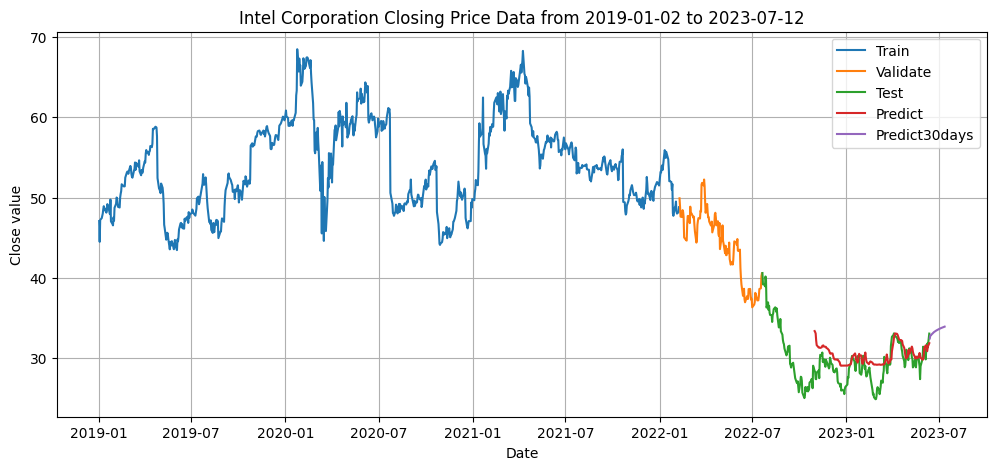

In [21]:
plt.figure(figsize=(12, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(train_data))

plt.plot(df.index[train_size : train_size + val_size], scaler.inverse_transform(val_data))

plt.plot(df.index[train_size + val_size : ], scaler.inverse_transform(test_data))

plt.plot(df.index[train_size + val_size + best_window_size + 1: ], best_y_pred)

plt.plot(index_next_30_days, scaler.inverse_transform(np.array(y_next_30_days).reshape(-1, 1)))

plt.legend(['Train', 'Validate', 'Test', 'Predict', 'Predict30days'])

plt.grid()
plt.title(f"Intel Corporation Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('TCAN_712_INTC.png')
plt.show()